In [1]:
import torch
import numpy as np
import pandas as pd

from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader

torch.manual_seed(611)

In [2]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [3]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values.argmax(1)
etiquetasN = Clases

In [4]:
features = 'VGGish'
# mod_encoder = 'GAT'; KN = 13
mod_encoder = 'GCN'; KN = 8

train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract=features)
print(len(train_dataset))

92


In [5]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

RZUA01
Data1.shape=torch.Size([3, 24, 128])
RZUA02
Data1.shape=torch.Size([3, 24, 128])
RZUA04
Data1.shape=torch.Size([3, 24, 128])
RZUA05
Data1.shape=torch.Size([3, 24, 128])
RZUA06
Data1.shape=torch.Size([3, 24, 128])
RZUA07
Data1.shape=torch.Size([3, 24, 128])
RZUA08
Data1.shape=torch.Size([3, 24, 128])
RZUA09
Data1.shape=torch.Size([3, 24, 128])
RZUA10
Data1.shape=torch.Size([3, 24, 128])
RZUB01
Data1.shape=torch.Size([3, 24, 128])
RZUB03
Data1.shape=torch.Size([3, 24, 128])
RZUB04
Data1.shape=torch.Size([3, 24, 128])
RZUB05
Data1.shape=torch.Size([3, 24, 128])
RZUB06
Data1.shape=torch.Size([3, 24, 128])
RZUB07
Data1.shape=torch.Size([3, 24, 128])
RZUB08
Data1.shape=torch.Size([3, 24, 128])
RZUB09
Data1.shape=torch.Size([3, 24, 128])
RZUB10
Data1.shape=torch.Size([3, 24, 128])
RZUB11
Data1.shape=torch.Size([3, 24, 128])
RZUC01
Data1.shape=torch.Size([3, 24, 128])
RZUC02
Data1.shape=torch.Size([3, 24, 128])
RZUC03
Data1.shape=torch.Size([3, 24, 128])
RZUC05
Data1.shape=torch.Size([3

In [6]:
def min_max_normalize_along_dim(tensor, dim):
    # Get min and max values along the specified dimension, keeping dimensions
    min_vals, _ = torch.min(tensor, dim=dim, keepdim=True)
    max_vals, _ = torch.max(tensor, dim=dim, keepdim=True)
    
    # Handle the case where min and max are the same (to avoid division by zero)
    diff = max_vals - min_vals
    diff[diff == 0] = 1.0  # Replace zeros with ones to avoid division by zero
    
    # Normalize the tensor
    normalized = (tensor - min_vals) / diff
    
    return normalized

In [7]:
x = min_max_normalize_along_dim(x, dim=2)
x.shape

torch.Size([3, 92, 24, 128])

## Edge Creation

In [8]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [9]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=5)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

max_nodes = max([data.num_nodes for data in graphs])
num_feat = graphs[0].x.shape[-1]
num_feat

Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True


128

In [10]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

In [11]:
del x, unpacked_data, train_dataset

## Cargar modelo

In [12]:
from models import MatrixGCNVAE_MT, MatrixGATVAE_MT

In [13]:
if mod_encoder == "GCN":
    model = MatrixGCNVAE_MT(in_channels=64*num_feat, hidden_channels=4*num_feat, latent_dim=int(num_feat/8), num_nodes=max_nodes, num_classes=3)
elif mod_encoder == "GAT":
    model = MatrixGATVAE_MT(in_channels=64*num_feat, hidden_channels=4*num_feat, latent_dim=int(num_feat/8), num_nodes=max_nodes, num_classes=3)
else:
    print("Error")

In [14]:
#load model
model.load_state_dict(torch.load(f'modelsGVAE_semi/{features}_{mod_encoder}_model_weights.pth'))

<All keys matched successfully>

## Eval


In [15]:
# Generate embeddings
model.eval()
model.double()
embeddings = torch.empty(92,0)
with torch.no_grad():
    for graph in train_loader:
        _, _, mu, logvar,_ = model(graph.x.double(), graph.edge_index)
        embs = model.reparameterize(mu, logvar)
        embeddings = torch.cat((embeddings,mu), dim = 1)

In [16]:
print(embeddings.shape)
embeddings = (embeddings - embeddings.min(0).values)/(embeddings.max(0).values - embeddings.min(0).values)

torch.Size([92, 48])


In [17]:
df_map = pd.read_csv('./data/ReyZamuro_latlon.csv',index_col='field_numb')
df_map = df_map.drop('RZUA03b')

## Matriz de similitud

In [18]:
embs = embeddings.numpy()
sim_mat = (embs@embs.T)/int(num_feat/8)
sim_mat

array([[0.7960803 , 0.78740876, 0.71625989, ..., 0.60395395, 0.58541505,
        0.71909942],
       [0.78740876, 0.77938362, 0.71074133, ..., 0.59617971, 0.57834088,
        0.71337862],
       [0.71625989, 0.71074133, 0.83543889, ..., 0.61590013, 0.63471996,
        0.78471185],
       ...,
       [0.60395395, 0.59617971, 0.61590013, ..., 0.93399038, 0.60836428,
        0.78616417],
       [0.58541505, 0.57834088, 0.63471996, ..., 0.60836428, 0.73112181,
        0.64675179],
       [0.71909942, 0.71337862, 0.78471185, ..., 0.78616417, 0.64675179,
        0.90503574]])

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils import edge_index_to_adjacency

In [20]:
adj_graph = edge_index_to_adjacency(graph.edge_index)

## Post-process graph

In [21]:
graphs_ = edge_creation_nodeinfo(embeddings.unsqueeze(0),'knn', k_neigh=KN)
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 48], edge_index=[2, 926]) connected? True
Is the graph undirected True


In [22]:
import networkx as nx

def pyg_to_networkx(data):
    # Convert PyG data to NetworkX graph
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(range(data.num_nodes))
    
    # Add edges with weights if available
    edges = data.edge_index.t().numpy()
    
    # Check if edge weights are available
    if hasattr(data, 'edge_weight') and data.edge_weight is not None:
        # Add edges with weights
        edge_weights = {tuple(edge): weight.item() for edge, weight in zip(edges, data.edge_weight)}
        for edge, weight in edge_weights.items():
            G.add_edge(edge[0], edge[1], weight=weight)
    else:
        # Add edges without weights
        G.add_edges_from(edges)
    
    # Optionally add node and edge attributes
    if data.x is not None:
        nx.set_node_attributes(G, {i: data.x[i].numpy() for i in range(data.num_nodes)}, 'features')
    
    if data.edge_attr is not None:
        edge_attrs = {tuple(edge): data.edge_attr[i].numpy() for i, edge in enumerate(edges)}
        nx.set_edge_attributes(G, edge_attrs, 'attributes')
    
    return G

In [23]:
import geopandas as gpd

#función que permite plotear nodos en posición geográfica deseada
def same_posicion_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud_IG, df.latitude_IG)) #objeto geometrico para respetar posiciones
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

coordinates = same_posicion_data(df_map)

In [24]:
def adjacency_to_edge_weights(adj_matrix, edge_index):
    """
    Convert adjacency matrix of weights to edge_weight tensor using edge_index.
    
    Args:
        adj_matrix: Tensor of shape [num_nodes, num_nodes] containing edge weights
        edge_index: Tensor of shape [2, num_edges] containing edge indices
        
    Returns:
        edge_weight: Tensor of shape [num_edges] containing weights for each edge
    """
    # Get source and target nodes for each edge
    src, dst = edge_index[0], edge_index[1]
    
    # Extract weights from adjacency matrix based on edge indices
    edge_weight = adj_matrix[src, dst]
    
    return edge_weight

In [25]:
edge_weight = adjacency_to_edge_weights(sim_mat, graphs_[0].edge_index)
edge_weight.shape

(926,)

In [26]:
graphs_[0].edge_weight = edge_weight

In [130]:
G = pyg_to_networkx(graphs_[0])

nodes = list(G.nodes())
positions = dict(zip(G.nodes, coordinates))


In [131]:
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 0.7874087614934553}), (0, 17, {'weight': 0.7950547478336588}), (0, 21, {'weight': 0.7907634930489954}), (0, 29, {'weight': 0.749131308569529}), (0, 33, {'weight': 0.7873498136146744}), (0, 43, {'weight': 0.7927065251685619}), (0, 46, {'weight': 0.7720521205625595}), (0, 85, {'weight': 0.7249504542458376}), (1, 17, {'weight': 0.7867141850732244}), (1, 21, {'weight': 0.7825476457616934}), (1, 29, {'weight': 0.7434124655687028}), (1, 33, {'weight': 0.779175808424312}), (1, 43, {'weight': 0.7843012608168197}), (1, 46, {'weight': 0.7656322022433001}), (1, 85, {'weight': 0.7203438912247708}), (2, 9, {'weight': 0.7372989675931136}), (2, 16, {'weight': 0.7849774565582847}), (2, 32, {'weight': 0.7909593762652488}), (2, 47, {'weight': 0.8365984538768528}), (2, 51, {'weight': 0.8354388921307667}), (2, 58, {'weight': 0.8289945544353008}), (2, 63, {'weight': 0.7492208138658906}), (2, 66, {'weight': 0.7372989675931136}), (2, 71, {'weight': 0.8365984538768529}), (2, 80

## Métricas

In [132]:
nx.density(G)


0.110606784519828

In [133]:
nx.diameter(G,weight="weight")

4.439528235702017

In [134]:
nx.average_shortest_path_length(G,weight="weight")

2.2761771342384134

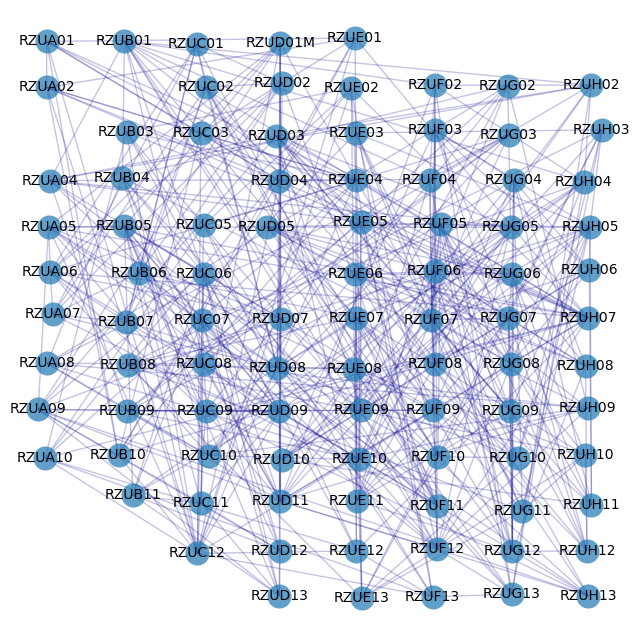

In [135]:
edge_weights = [1 for u, v in G.edges()]
# edge_weights = [3*sim_mat[u,v]  for u, v in G.edges()]
G.remove_node(35)
# Dibujar los nodos del grafo con tamaño personalizado
node_size = 300
node_border_color = 'white'
node_border_width = 0
node_labels = {node: df_map.index[node] for node in G.nodes()}

fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_nodes(G, positions, nodelist=G.nodes(), node_size=node_size,# node_color=node_color,
                       linewidths=node_border_width, edgecolors=node_border_color, alpha=0.7)
nx.draw_networkx_labels(G, positions, labels=node_labels, font_color='black', font_size=10)

# escalar los anchos de los enlaces
# min_width = 1  # ancho mínimo de enlace
# max_width = 5  # ancho máximo de enlace
# scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights] #si valor de enlace es cercano al umbral, el color se acercará al azul, si es mucho mayor al umbral se acerca al rojo

# Dibujar los enlaces del grafo con ancho constante y colores personalizados
nx.draw_networkx_edges(G, positions, width=edge_weights, edge_color="darkblue", alpha=0.23) # se puede ver tambien con colores cambiando edge_color=edge_colors
plt.axis('off')
plt.margins(0)
plt.box(False)
# fig.savefig('./results/graph_resGCN_VGGish.pdf', transparent=True, dpi=300, bbox_inches='tight',pad_inches=0.0)

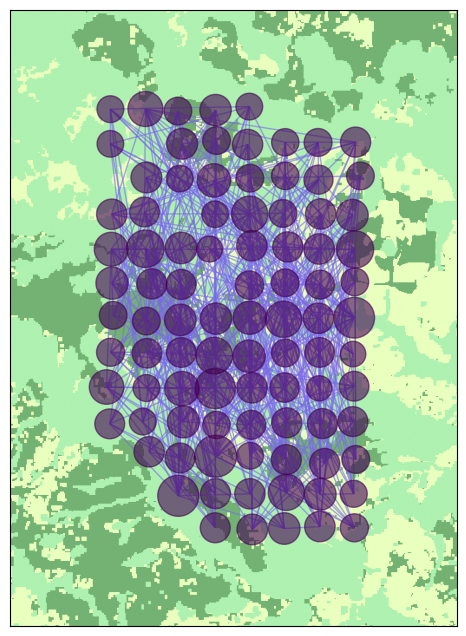

In [136]:
from matplotlib.colors import LinearSegmentedColormap
import rasterio
from rasterio.plot import show

H = G.copy()


# Extract latitudes and longitudes from dataframe
locations = df_map.reset_index().rename(columns={'index': 'name'})
lats = locations['latitude_IG'].values
lons = locations['longitud_IG'].values

bounds = (np.min(lats), np.max(lats), np.min(lons), np.max(lons))

colors = [(115/255,178/255,115/255),(233/255,255/255,190/255), (174/255,241/255,176/255)] 
cmap = LinearSegmentedColormap.from_list('my_cmp', colors, N=3)


tif_path = r'./data/wgs84.tif'

img = rasterio.open(tif_path)

fig, ax = plt.subplots(figsize = (8, 8))

r = rasterio.plot.show(img, cmap=cmap, ax=ax)

centrality = nx.betweenness_centrality(H, weight="weight",endpoints=True)
degrees = H.degree(weight="weight")



#### draw graph ####
node_color = [0 for n in H]
node_size = [v * 60 for v in dict(degrees).values()]
nx.draw_networkx(
    H,
    pos=positions,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="mediumslateblue", #https://graphviz.org/pdf/dotguide.pdf
    alpha=0.6,
)


margin = 0.01
ax.set_xlim(bounds[2]-margin, bounds[3]+margin)
ax.set_ylim(bounds[0]-margin, bounds[1]+margin)

fig.savefig(f'./results/graph_eb_geo_{features}_{mod_encoder}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=-0.4)
plt.show()

# New tests for analysis

In [137]:
centrality = nx.betweenness_centrality(H, weight="weight",endpoints=True)
centrality = dict(H.degree(weight="weight"))

In [138]:
p90 = np.percentile(list(centrality.values()), 95)

In [139]:
higher_cent = [key for key, value in centrality.items() if value > p90]

In [140]:
higher_cent

[12, 29, 38, 40, 85]

In [141]:
np.set_printoptions(formatter={'float_kind': lambda x: "{:.4f}".format(x)})
for i in higher_cent:
    print(f'Grabadora {df_data.index[i]} Cobertura original {df_data.iloc[i].to_numpy()}')
    print(f'Centralidad: {centrality[i]}')
    neighs = list(H.neighbors(i))
    print(f'Número de vecinos: {len(neighs)}')
    print(df_data.index[neighs])
    print(f'Cobertura Media de vecinos: {df_data.iloc[neighs].values.mean(axis=0)} \n\
        Desviación estándar: {df_data.iloc[neighs].values.std(axis=0)} ')
    print(f'{77*"*"}')

    

Grabadora RZUB05 Cobertura original [0.8779 0.0126 0.1095]
Centralidad: 12.225340690425243
Número de vecinos: 14
Index(['RZUA05', 'RZUB11', 'RZUC06', 'RZUC07', 'RZUC09', 'RZUC11', 'RZUC12',
       'RZUD01M', 'RZUD07', 'RZUD09', 'RZUD11', 'RZUD12', 'RZUD13', 'RZUH07'],
      dtype='object', name='field_numb')
Cobertura Media de vecinos: [0.7512 0.0401 0.2087] 
        Desviación estándar: [0.1282 0.0542 0.1376] 
*****************************************************************************
Grabadora RZUC12 Cobertura original [0.9601 0.0000 0.0399]
Centralidad: 14.550494170928594
Número de vecinos: 18
Index(['RZUA01', 'RZUA02', 'RZUA05', 'RZUA10', 'RZUB03', 'RZUB05', 'RZUB10',
       'RZUC03', 'RZUC05', 'RZUC09', 'RZUD04', 'RZUD09', 'RZUE01', 'RZUE02',
       'RZUE04', 'RZUE12', 'RZUF13', 'RZUH07'],
      dtype='object', name='field_numb')
Cobertura Media de vecinos: [0.9632 0.0131 0.0237] 
        Desviación estándar: [0.0656 0.0282 0.0444] 
**********************************************

In [142]:
positions

{0: array([-73.4117, 3.5559]),
 1: array([-73.4117, 3.5523]),
 2: array([-73.4115, 3.5450]),
 3: array([-73.4116, 3.5414]),
 4: array([-73.4115, 3.5378]),
 5: array([-73.4114, 3.5345]),
 6: array([-73.4116, 3.5307]),
 7: array([-73.4121, 3.5271]),
 8: array([-73.4117, 3.5233]),
 9: array([-73.4080, 3.5559]),
 10: array([-73.4079, 3.5488]),
 11: array([-73.4081, 3.5452]),
 12: array([-73.4080, 3.5414]),
 13: array([-73.4074, 3.5378]),
 14: array([-73.4079, 3.5339]),
 15: array([-73.4079, 3.5306]),
 16: array([-73.4079, 3.5270]),
 17: array([-73.4083, 3.5235]),
 18: array([-73.4076, 3.5204]),
 19: array([-73.4047, 3.5557]),
 20: array([-73.4042, 3.5523]),
 21: array([-73.4045, 3.5487]),
 22: array([-73.4043, 3.5415]),
 23: array([-73.4043, 3.5377]),
 24: array([-73.4044, 3.5340]),
 25: array([-73.4043, 3.5307]),
 26: array([-73.4042, 3.5269]),
 27: array([-73.4041, 3.5235]),
 28: array([-73.4044, 3.5197]),
 29: array([-73.4046, 3.5158]),
 30: array([-73.4008, 3.5558]),
 31: array([-73.40

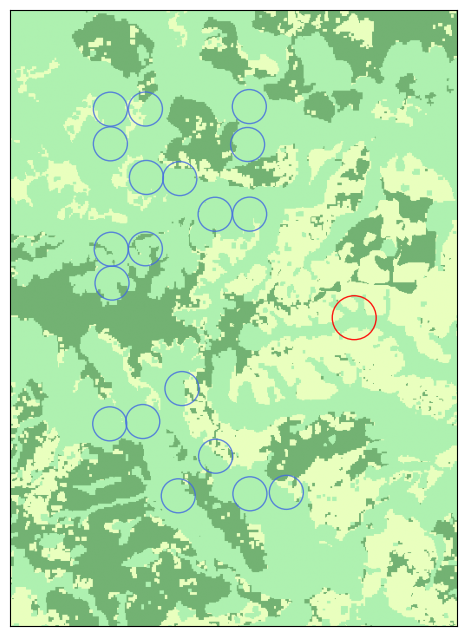

In [148]:
from matplotlib.colors import LinearSegmentedColormap
import rasterio
from rasterio.plot import show

H = G.copy()


# Extract latitudes and longitudes from dataframe
locations = df_map.reset_index().rename(columns={'index': 'name'})
lats = locations['latitude_IG'].values
lons = locations['longitud_IG'].values

bounds = (np.min(lats), np.max(lats), np.min(lons), np.max(lons))

colors = [(115/255,178/255,115/255),(233/255,255/255,190/255), (174/255,241/255,176/255)] 
cmap = LinearSegmentedColormap.from_list('my_cmp', colors, N=3)


tif_path = r'./data/wgs84.tif'

img = rasterio.open(tif_path)

fig, ax = plt.subplots(figsize = (8, 8))

r = rasterio.plot.show(img, cmap=cmap, ax=ax)

centrality = nx.betweenness_centrality(H, weight="weight",endpoints=True)
degrees = dict(H.degree(weight="weight"))

### draw graph ####
node_edge_colors = ['royalblue' for n in neighs]
node_size = [v * 60 for v in {key: degrees[key] for key in neighs if key in degrees}.values()]

neighs = list(H.neighbors(i))
nodes_to_plot = [i] + neighs
subgraph = H.subgraph(nodes_to_plot)

pos={key: positions[key] for key in nodes_to_plot if key in degrees}

# Draw edges
# nx.draw_networkx_edges(subgraph, pos, alpha=0.6, width=0.5, edge_color='gray')

# Draw target node
nx.draw_networkx_nodes(subgraph, pos, 
                        nodelist=[i],
                        node_color='none',
                        edgecolors=['red'],
                        node_size=1000,
                        alpha=0.9)

# Draw neighbor nodes
nx.draw_networkx_nodes(subgraph, pos,
                        nodelist=neighs,
                        edgecolors=node_edge_colors,
                        node_color='none',
                        node_size=600,
                        alpha=0.8)


# nx.draw_networkx(
#     subgraph,
#     pos={key: positions[key] for key in neighs if key in degrees},
#     with_labels=False,
#     nodelist = neighs,
#     node_color=node_color,
#     node_size=node_size,
#     edge_color="mediumslateblue", #https://graphviz.org/pdf/dotguide.pdf
#     alpha=0.6,
# )

# nx.draw_networkx_nodes(subgraph, {i:positions[i]}, 
#                           nodelist=[i],
#                           node_color='black', 
#                           node_size=1000,
#                           alpha=0)


margin = 0.01
ax.set_xlim(bounds[2]-margin, bounds[3]+margin)
ax.set_ylim(bounds[0]-margin, bounds[1]+margin)

# # fig.savefig(f'./results/graph_eb_geo_{features}_{mod_encoder}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=-0.4)
plt.show()

Grabadora RZUB05 Cobertura original [0.8779 0.0126 0.1095]
Grado: 0.05543345543345543
Número de vecinos: 14
Index(['RZUA05', 'RZUB11', 'RZUC06', 'RZUC07', 'RZUC09', 'RZUC11', 'RZUC12',
       'RZUD01M', 'RZUD07', 'RZUD09', 'RZUD11', 'RZUD12', 'RZUD13', 'RZUH07'],
      dtype='object', name='field_numb')
Cobertura Media de vecinos: [0.7512 0.0401 0.2087] 
        Desviación estándar: [0.1282 0.0542 0.1376] 
*****************************************************************************


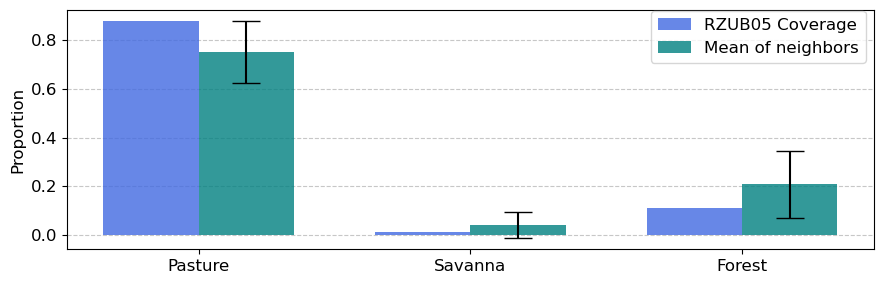

Grabadora RZUC12 Cobertura original [0.9601 0.0000 0.0399]
Grado: 0.0485958485958486
Número de vecinos: 18
Index(['RZUA01', 'RZUA02', 'RZUA05', 'RZUA10', 'RZUB03', 'RZUB05', 'RZUB10',
       'RZUC03', 'RZUC05', 'RZUC09', 'RZUD04', 'RZUD09', 'RZUE01', 'RZUE02',
       'RZUE04', 'RZUE12', 'RZUF13', 'RZUH07'],
      dtype='object', name='field_numb')
Cobertura Media de vecinos: [0.9632 0.0131 0.0237] 
        Desviación estándar: [0.0656 0.0282 0.0444] 
*****************************************************************************


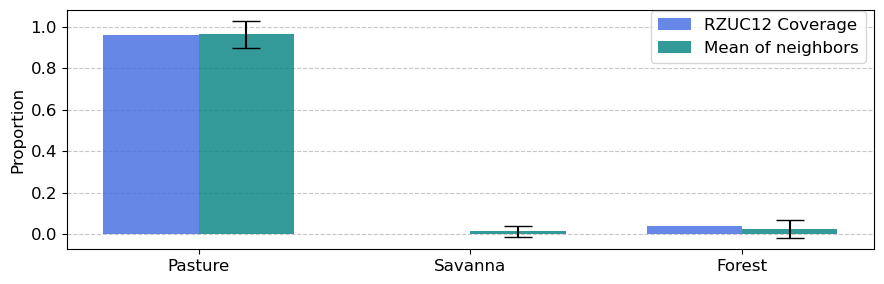

Grabadora RZUD09 Cobertura original [0.8199 0.0718 0.1083]
Grado: 0.04908424908424908
Número de vecinos: 16
Index(['RZUA05', 'RZUA09', 'RZUB05', 'RZUB11', 'RZUC06', 'RZUC07', 'RZUC09',
       'RZUC11', 'RZUC12', 'RZUD01M', 'RZUD07', 'RZUD11', 'RZUD12', 'RZUD13',
       'RZUH04', 'RZUH13'],
      dtype='object', name='field_numb')
Cobertura Media de vecinos: [0.7087 0.0741 0.2172] 
        Desviación estándar: [0.1338 0.0965 0.1198] 
*****************************************************************************


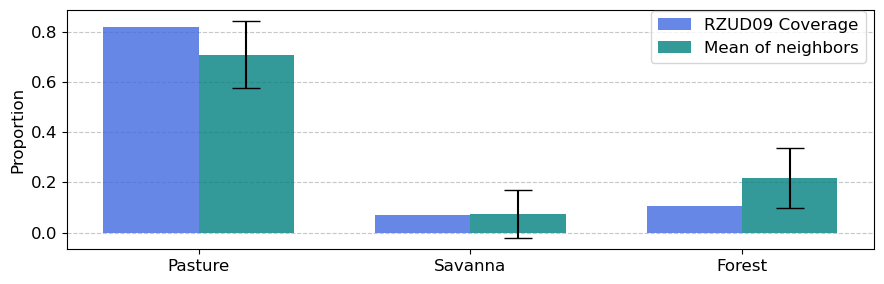

Grabadora RZUD11 Cobertura original [0.7629 0.1678 0.0693]
Grado: 0.0862026862026862
Número de vecinos: 19
Index(['RZUA08', 'RZUA09', 'RZUB01', 'RZUB04', 'RZUB05', 'RZUC08', 'RZUC09',
       'RZUD01M', 'RZUD07', 'RZUD09', 'RZUF02', 'RZUF09', 'RZUF12', 'RZUG02',
       'RZUH02', 'RZUH04', 'RZUH07', 'RZUH09', 'RZUH13'],
      dtype='object', name='field_numb')
Cobertura Media de vecinos: [0.7712 0.1609 0.0679] 
        Desviación estándar: [0.1205 0.1033 0.0795] 
*****************************************************************************


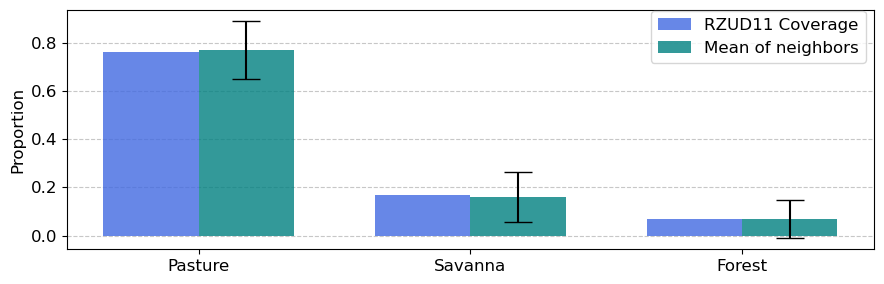

Grabadora RZUH07 Cobertura original [0.9569 0.0431 0.0000]
Grado: 0.284004884004884
Número de vecinos: 19
Index(['RZUA01', 'RZUA02', 'RZUA05', 'RZUA06', 'RZUA10', 'RZUB01', 'RZUB03',
       'RZUB05', 'RZUB10', 'RZUC03', 'RZUC09', 'RZUC12', 'RZUD04', 'RZUD11',
       'RZUE01', 'RZUE02', 'RZUE04', 'RZUE12', 'RZUF12'],
      dtype='object', name='field_numb')
Cobertura Media de vecinos: [0.9310 0.0420 0.0270] 
        Desviación estándar: [0.0976 0.0844 0.0403] 
*****************************************************************************


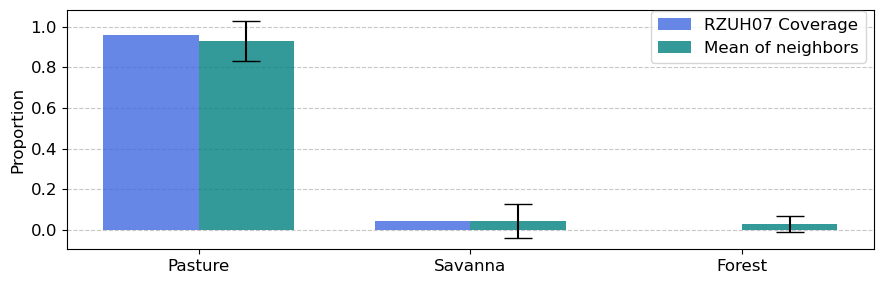

In [ ]:
#Guardar como imagenes
def visualizar_vectores(vector_referencia, media, desv_estandar, recorder_name):
    """
    Visualiza un vector de referencia junto con la media y desviación estándar de un conjunto de datos.
    
    Parámetros:
    - vector_referencia: Lista o array de 3 valores
    - datos: Lista de listas o array 2D donde cada fila es un vector de 3 valores
    """
    plt.rcParams.update({'font.size': 12})
    # Convertir a arrays de numpy si no lo son ya
    vector_referencia = np.array(vector_referencia)
    
    # Configurar el gráfico
    fig, ax = plt.subplots(figsize=(9, 3))
    
    # Posiciones en el eje x para las barras
    dimensiones = ['Pasture', 'Savanna', 'Forest']
    x = np.arange(len(dimensiones))
    width = 0.35  # Ancho de las barras
    
    # Graficar el vector de referencia (barras azules)
    bars1 = ax.bar(x - width/2, vector_referencia, width, label=f'{recorder_name} Coverage', 
                color='royalblue', alpha=0.8)
    
    # Graficar la media con barras de error para la desviación estándar (barras verdes)
    bars2 = ax.bar(x + width/2, media, width, label='Mean of neighbors', 
                yerr=desv_estandar, capsize=10, color='teal', alpha=0.8)
    
    ax.legend(loc='best',  bbox_to_anchor=(0, 0, 1, 1.03))
    # Añadir etiquetas, título y leyenda
    # ax.set_xlabel('Coverage')
    ax.set_ylabel('Proportion')
    # ax.set_title('Comparación entre vector de referencia y estadísticas de los datos')
    ax.set_xticks(x)
    ax.set_xticklabels(dimensiones)
    
   
    # Ajustar el diseño
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    return fig


np.set_printoptions(formatter={'float_kind': lambda x: "{:.4f}".format(x)})
for n, i in enumerate(higher_cent):
    print(f'Grabadora {df_data.index[i]} Cobertura original {df_data.iloc[i].to_numpy()}')
    print(f'Grado: {centrality[i]}')
    neighs = list(H.neighbors(i))
    print(f'Número de vecinos: {len(neighs)}')
    print(df_data.index[neighs])
    print(f'Cobertura Media de vecinos: {df_data.iloc[neighs].values.mean(axis=0)} \n\
        Desviación estándar: {df_data.iloc[neighs].values.std(axis=0)} ')
    print(f'{77*"*"}')

    fig = visualizar_vectores(df_data.iloc[i].to_numpy(), df_data.iloc[neighs].values.mean(axis=0),df_data.iloc[neighs].values.std(axis=0), df_data.index[i])
    plt.tight_layout()
    fig.savefig(f'./results/Coverage{n+1}_{df_data.index[i]}_{mod_encoder}_{features}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=0.0)
    plt.show()

# New numeric Tests

In [199]:
norms = np.linalg.norm(embs, axis=1)
sim_mat = embs @ embs.T / (norms[:, np.newaxis] @ norms[np.newaxis, :])
sim_mat

array([[1.0000, 0.9996, 0.8783, ..., 0.7004, 0.7673, 0.8472],
       [0.9996, 1.0000, 0.8808, ..., 0.6988, 0.7661, 0.8494],
       [0.8783, 0.8808, 1.0000, ..., 0.6972, 0.8121, 0.9024],
       ...,
       [0.7004, 0.6988, 0.6972, ..., 1.0000, 0.7362, 0.8551],
       [0.7673, 0.7661, 0.8121, ..., 0.7362, 1.0000, 0.7951],
       [0.8472, 0.8494, 0.9024, ..., 0.8551, 0.7951, 1.0000]])

In [200]:
covs = df_data.values

In [201]:
idx = 0

In [202]:
covs.shape

(92, 3)

In [241]:
np.mean(covs, axis=0)

array([0.5119, 0.2873, 0.2008])

In [238]:
for idx in range(92):
    E_cov = covs[idx]
    weighted_covs = sim_mat[idx][:, np.newaxis]*covs/(sum(sim_mat[idx])-1.0)
    new_arr = np.delete(weighted_covs, idx, axis=0) #remove reference node info
    print(f' {df_data.index[idx]} \n Reference Cov: {E_cov} \n Weighted Cov: {np.sum(new_arr, axis=0)} \n{42*"*"}')

 RZUA01 
 Reference Cov: [1.0000 0.0000 0.0000] 
 Weighted Cov: [0.5287 0.2804 0.1908] 
******************************************
 RZUA02 
 Reference Cov: [1.0000 0.0000 0.0000] 
 Weighted Cov: [0.5293 0.2799 0.1907] 
******************************************
 RZUA04 
 Reference Cov: [0.5893 0.4107 0.0000] 
 Weighted Cov: [0.5228 0.2851 0.1921] 
******************************************
 RZUA05 
 Reference Cov: [0.8927 0.0000 0.1073] 
 Weighted Cov: [0.5169 0.2819 0.2013] 
******************************************
 RZUA06 
 Reference Cov: [0.9384 0.0000 0.0616] 
 Weighted Cov: [0.5138 0.2836 0.2026] 
******************************************
 RZUA07 
 Reference Cov: [0.0000 0.0000 1.0000] 
 Weighted Cov: [0.5066 0.2869 0.2065] 
******************************************
 RZUA08 
 Reference Cov: [0.8293 0.1707 0.0000] 
 Weighted Cov: [0.5305 0.2794 0.1901] 
******************************************
 RZUA09 
 Reference Cov: [0.5379 0.2449 0.2172] 
 Weighted Cov: [0.5162 0.2847 0.19

 RZUA01 
 Reference Cov: [1.0000 0.0000 0.0000] 
 Weighted Cov: [0.5287 0.2804 0.1908] 
******************************************


# Fin